In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook, tqdm

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset

from collections import OrderedDict

import architectures

%matplotlib inline

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
display(device)

device(type='cuda', index=1)

## **1. Dataset pre-processing**

In [2]:
perm = np.load('perms_clear.npy')
pressure = np.load('pressures_clear.npy')

print('perm shape:', perm.shape)
print('pressure shape:', pressure.shape)

perm shape: (1317, 64, 64)
pressure shape: (1317, 21, 64, 64)


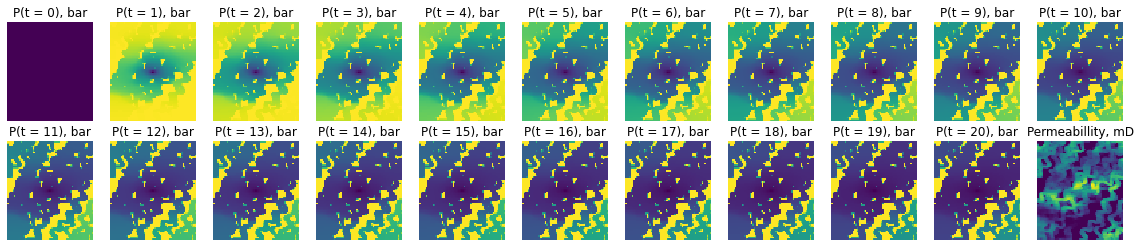

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=11, figsize=(20, 4))

plt.pcolormesh(perm[1])
plt.title('Permeabillity, mD')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('off')

k = 0
for i in range(2):
    for j in range(11):
        if 0 <= k <= 20:
            pcm = ax[i, j].pcolormesh(pressure[1][k])
            # cb = fig.colorbar(pcm, ax=ax[i, j])
            ax[i, j].set_title(f'P(t = {k}), bar')
            ax[i, j].set_xlabel('x')
            ax[i, j].set_ylabel('y')            
            ax[i, j].axis('off')
            k += 1

plt.show()
        

# **3. Model FNO**

In [4]:
perm = np.load('perms_clear.npy')
pressure = np.load('pressures_clear.npy')

print('perm shape:', perm.shape)
print('pressure shape:', pressure.shape)

perm shape: (1317, 64, 64)
pressure shape: (1317, 21, 64, 64)


In [5]:
x = pressure[:,1:11]
y = pressure[:,11:] 

print('x:', x.shape)
print('y:', y.shape)

x: (1317, 10, 64, 64)
y: (1317, 10, 64, 64)


In [6]:
# x, z = [], []
# for i in notebook.tqdm(range(len(pressure))):
#     x.append(pressure[i][1].reshape(1,64,64))
# x = np.stack(tuple(x))
# x = np.concatenate((x, pressure[:, 1:2]), axis=1)
# y = pressure[:,[7,14,20]] 

# print('x:', x.shape)
# print('y:', y.shape)

In [7]:
# x, z = [], []
# for i in notebook.tqdm(range(len(pressure))):
#     x.append(pressure[i][1].reshape(1,64,64))
    
# x = np.stack(tuple(x))
# # x = np.concatenate((x, pressure[:, 1:2]), axis=1)
# y = pressure[:,[7,14,20]] 

# print('x:', x.shape)
# print('y:', y.shape)

In [8]:
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42, shuffle=False)
print(f'The train size: {len(x_train)}',
      f'\nThe val size: {len(x_val)}',
     f'\nThe test size: {len(x_test)}')

x_train = torch.from_numpy(x_train)
x_val = torch.from_numpy(x_val)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)

The train size: 1053 
The val size: 132 
The test size: 132


In [9]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
from torch.fft import fft2, ifft

In [11]:
(fft2(next(iter(train_loader))[0]) * 1e-4).shape

torch.Size([8, 10, 64, 64])

In [12]:
def train(model, criterion, train_loader, val_loader, scheduler=None, 
             path ='/home/', name='name.pth',
             num_epochs=100, learning_rate=3e-4):
    logging = []
    best_val_loss = np.inf
    val_loss = 0
    f = 0
    pbar = notebook.tqdm(range(num_epochs), colour="MAGENTA")
    for epoch in pbar:
        model.train()
        
        train_batch_loss = []
        for step, batch in enumerate(train_loader):
            sample, target = batch
            sample, target = sample.to(device, torch.float), target.to(device, torch.float) 
            pred = model(sample)
            loss = criterion(pred, target)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_batch_loss.append(loss.item())
            pbar.set_description(f"Epoch: {epoch+1} / {num_epochs}, Batch: {step+1} / {len(train_loader)}, Train Loss: {train_batch_loss[-1]:.4f}, Val Loss: {val_loss:.2f}, ES Ticker: {f} / {10}")
        train_loss = np.mean(train_batch_loss)
    
        model.eval()
        
        val_batch_loss = []
        for batch in val_loader:
            sample, target = batch
            sample, target = sample.to(device, torch.float), target.to(device, torch.float)
            
            pred = model(sample)
            loss = criterion(pred, target)
            val_batch_loss.append(loss.item())
            
        val_loss = np.mean(val_batch_loss)
        
        # if epoch % 100 == 0:
        #     folder = path
        #     model_name = f'PINN_non_steady_{epoch}.pth'
        #     model_path = folder + model_name
        #     torch.save(model, model_path)
          
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            folder = path
            model_path = folder + name
            torch.save(model, model_path)
        
        if scheduler is not None:
            scheduler.step()
            
        logging.append(np.array([epoch, train_loss, val_loss]))
        if val_loss > np.min(logging, axis=0)[2]:
            f += 1
        else:
            f = 0
            # folder = path
            # model_name_cur = 'PINN_non_steady_current_sch.pth'
            # model_path = folder + model_name_cur
            # torch.save(model, model_path)
        
        if f >= 10:
            print("Early stopping...")
            break

        #print(f'epoch: {epoch}, train_loss: {train_loss}, val_loss {val_loss}')

    return logging

In [13]:
from neuralop.models import FNO

model = FNO(n_modes=(16, 16), hidden_channels=64,
                in_channels=10, out_channels=10).to(device)

In [14]:
# model = FourierNeuralOperator(modes=16).to(device)
lr = 1e-4
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-3)
num_epochs = 10000
scheduler = None
criterion = nn.MSELoss()

logs = train(model, criterion, train_loader, val_loader, scheduler, 
             path='fineTunedModels/',
             name='FNO_best_10_10.pth',
             num_epochs=num_epochs, learning_rate=lr)

  0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping...


In [15]:
def logging_plot(logging, save_name='some_logging'):
    logging = np.array(logging)
    plt.plot(logging[:,0], logging[:,1], label='train_loss')
    plt.plot(logging[:,0], logging[:,2], label='val_loss')
    plt.legend()
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.ylim(np.min(logging[15:]), np.max(logging[15:]))
    np.save(f'{save_name}.npy', logging)
    plt.savefig('logging_plot_10_10.png')

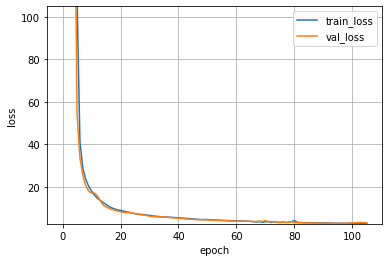

In [16]:
logging_plot(logs, 'piwsm_logging_FNO_pres_init_10_10')

In [17]:
folder = 'fineTunedModels/'
model_name_cur = 'FNO_best_10_10.pth'

In [18]:
model_path_cur = folder + model_name_cur
model = torch.load(model_path_cur)
model.to(device)
model.eval()
model.to(device)

FNO(
  (fno_blocks): FNOBlocks(
    (convs): FactorizedSpectralConv(
      (weight): ModuleList(
        (0): ComplexDenseTensor(shape=torch.Size([64, 64, 8, 8]), rank=None)
        (1): ComplexDenseTensor(shape=torch.Size([64, 64, 8, 8]), rank=None)
        (2): ComplexDenseTensor(shape=torch.Size([64, 64, 8, 8]), rank=None)
        (3): ComplexDenseTensor(shape=torch.Size([64, 64, 8, 8]), rank=None)
        (4): ComplexDenseTensor(shape=torch.Size([64, 64, 8, 8]), rank=None)
        (5): ComplexDenseTensor(shape=torch.Size([64, 64, 8, 8]), rank=None)
        (6): ComplexDenseTensor(shape=torch.Size([64, 64, 8, 8]), rank=None)
        (7): ComplexDenseTensor(shape=torch.Size([64, 64, 8, 8]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): Conv2d(64, 64,

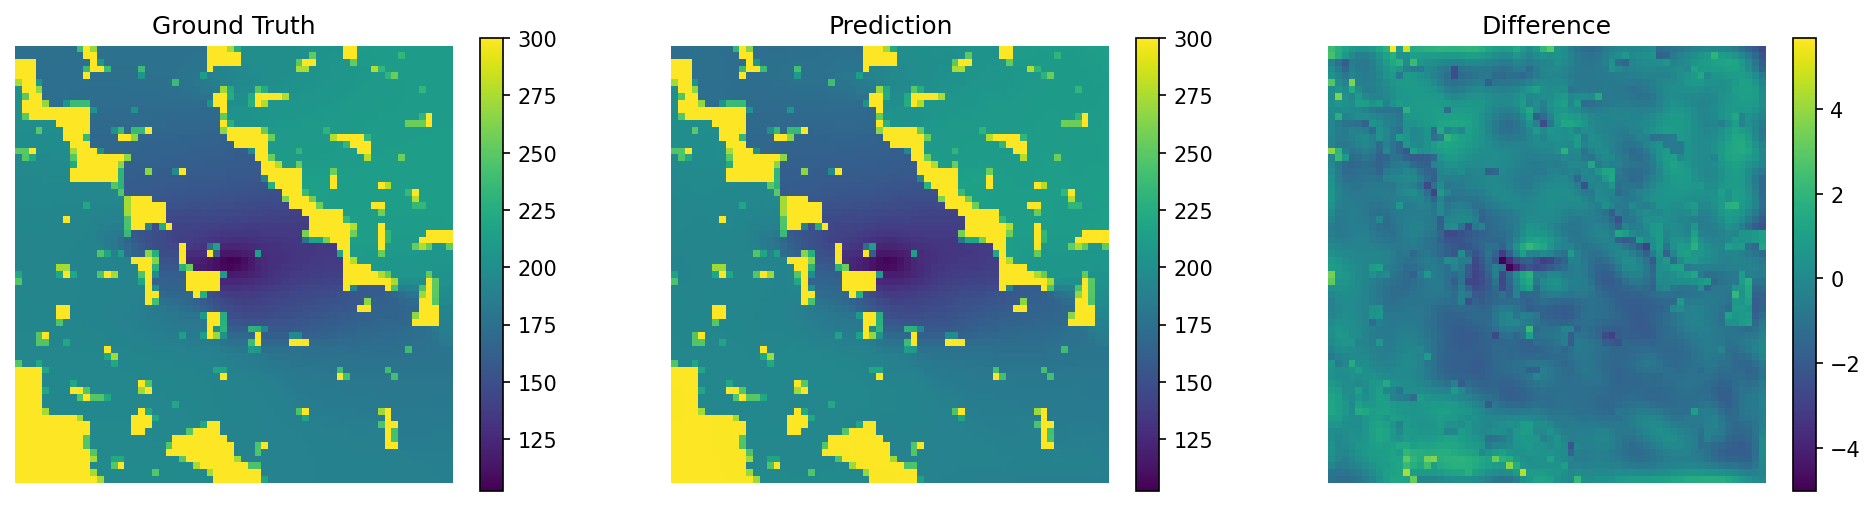

In [19]:
# 3 на 10
ex_x, ex_y = test_dataset[90]
ex_pred = model(ex_x.unsqueeze(0).to(device, dtype=torch.float)).cpu().detach().numpy()[0]
k = 2
target = ex_y.numpy()[k]
pred = ex_pred[k]
diff = ex_y.numpy()[k] - ex_pred[k]
dpi = 150

plt.figure(figsize=(16,4), dpi=dpi)
plt.subplot(131)
plt.imshow(target, vmin=target.min(), vmax=target.max())
plt.axis('off')
plt.subplots_adjust()
plt.colorbar()
plt.title('Ground Truth')
# plt.show()

plt.subplot(132)
plt.imshow(pred, vmin=target.min(), vmax=target.max())
plt.axis('off')
plt.subplots_adjust()
plt.colorbar()
plt.title('Prediction')
# plt.show()

plt.subplot(133)
plt.imshow(diff)
plt.axis('off')
plt.subplots_adjust()
plt.colorbar()
plt.title('Difference')
plt.savefig('FNO2D_res.png')
plt.show()

In [20]:
test_loss = []

for i in tqdm(range(len(test_dataset))):
    sample, target = test_dataset[i]
    sample, target = sample.to(device, torch.float), target.to(device, torch.float).unsqueeze(0)
    pred = model(sample.unsqueeze(0))
    loss = criterion(pred, target)
    test_loss.append(loss.item())

print(np.sqrt(np.mean(test_loss)))

100%|██████████| 132/132 [00:00<00:00, 188.64it/s]

1.578544073328445
